In [1]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import country_converter as coco

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)


Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


## Load all tweets of Coronavirus and virus stats 

In [34]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
all_tweets = spark.read.json("/mnt/datastore/data/coronavirus/*.json");
all_tweets.count()

27876312

In [35]:
all_tweets.printSchema()

root
 |-- author_handle: string (nullable = true)
 |-- geo_city: string (nullable = true)
 |-- geo_country: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- geo_point: string (nullable = true)
 |-- geo_state: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- main: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- published: string (nullable = true)
 |-- replied: boolean (nullable = true)
 |-- shared_type: string (nullable = true)
 |-- shares: long (nullable = true)
 |-- source_followers: long (nullable = true)
 |-- source_following: long (nullable = true)



In [36]:
all_tweets.where(col("geo_point").isNotNull()).count()

7288016

In [47]:
all_countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
europe_countries = all_countries[all_countries.region == "Europe"]


array(['AX', 'AL', 'AD', 'AT', 'BY', 'BE', 'BA', 'BG', 'HR', 'CZ', 'DK',
       'EE', 'FO', 'FI', 'FR', 'DE', 'GI', 'GR', 'GG', 'VA', 'HU', 'IS',
       'IE', 'IM', 'IT', 'JE', 'LV', 'LI', 'LT', 'LU', 'MT', 'MD', 'MC',
       'ME', 'NL', 'MK', 'NO', 'PL', 'PT', 'RO', 'RU', 'SM', 'RS', 'SK',
       'SI', 'ES', 'SJ', 'SE', 'CH', 'UA', 'GB'], dtype=object)

In [49]:
all_geo_tweets_eu = all_tweets.where(col("geo_point").isNotNull()).filter(col('geo_country').isin(europe_countries['alpha-2'].values.tolist()))
all_geo_tweets_eu.count()

1711799

In [53]:
all_geo_tweets_eu_count = all_geo_tweets_eu.select(F.date_format('published','yyyy-MM-dd').alias('date'), 'geo_point', "geo_point", "geo_city", "geo_country").groupby("date", 'geo_point', "geo_point", "geo_city", "geo_country").count().toPandas()
all_geo_tweets_eu_count.head(50)


,date,geo_point,geo_point,geo_city,geo_country,count
0,2020-03-14,"51.75,-0.33333","51.75,-0.33333",St Albans,GB,54
1,2020-03-14,"44.80401,20.46513","44.80401,20.46513",Belgrade,RS,177
2,2020-03-16,"48.70354,9.65209","48.70354,9.65209",Göppingen,DE,5
3,2020-03-09,"52.75172,0.39516","52.75172,0.39516",King's Lynn,GB,8
4,2020-03-12,"47.9959,7.85222","47.9959,7.85222",Freiburg,DE,47
5,2020-03-12,"52.09332,1.32042","52.09332,1.32042",Woodbridge,GB,6
6,2020-03-12,"51.3751,-2.36172","51.3751,-2.36172",Bath,GB,184
7,2020-03-03,"41.38879,2.15899","41.38879,2.15899",Barcelona,ES,872
8,2020-03-10,"53.41058,-2.97794","53.41058,-2.97794",Liverpool,GB,525
9,2020-03-09,"55.67594,12.56553","55.67594,12.56553",None,DK,62


In [58]:
all_geo_tweets_eu_count.sort_values(by=['date']).to_csv("all_geo_tweets_eu_count.csv", index=None)

In [4]:
coronavirus = pd.read_csv("/mnt/datastore/data/coronavirus_2020-03-16.csv", sep=";")
coronavirus['date'] = pd.to_datetime(coronavirus['Date'])
coronavirus_count = coronavirus.groupby([coronavirus.Pays, coronavirus.date.dt.year, coronavirus.date.dt.month, coronavirus.date.dt.day])[['Infections', 'Guerisons', 'Deces']].sum()
coronavirus_count.index.names = ['Pays', 'Year', 'Month','Day']
coronavirus_count = coronavirus_count.reset_index()
coronavirus_count['date'] = pd.to_datetime(coronavirus_count[['Year', 'Month', 'Day']])
coronavirus_count = coronavirus_count[['date', 'Pays', 'Infections', 'Guerisons', 'Deces']]
coronavirus_count = coronavirus_count.sort_values(by=['date'], ascending=True)

## Coronavirus

In [35]:
dates = pd.date_range(start='01/22/2020', end=pd.datetime.now().date())
coronavirus = pd.DataFrame(columns=['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'])

for date in dates: 
    try:
        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+ date.date().strftime('%m-%d-%Y')+ ".csv"
        daily_report = pd.read_csv(url)[['Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']]
        coronavirus = coronavirus.append(daily_report)
    except: 
        print("No Datas for "+ str(date))
        
coronavirus['Last Update'] = pd.to_datetime(coronavirus['Last Update']).dt.strftime("%Y-%m-%d")
coronavirus[['Confirmed', 'Deaths', 'Recovered']] = coronavirus[['Confirmed', 'Deaths', 'Recovered']].fillna(0)
coronavirus = coronavirus.rename(columns={"Last Update": "date", "Country/Region":"country"})     
coronavirus = coronavirus.drop_duplicates(subset =['country','date'], keep = False)

/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


No Datas for 2020-03-16 00:00:00


Province/State    3575
Country/Region    5890
date              5890
Confirmed         5890
Deaths            5890
Recovered         5890
Latitude          3072
Longitude         3072
dtype: int64

In [37]:
# Group by date and country
coronavirus_count = coronavirus.groupby([coronavirus['Country/Region'], coronavirus.date.dt.year, coronavirus.date.dt.month, coronavirus.date.dt.day])[['Confirmed', 'Deaths', 'Recovered']].sum()
coronavirus_count.index.names = ['Country/Region', 'Year', 'Month','Day']
coronavirus_count = coronavirus_count.reset_index()
coronavirus_count['date'] = pd.to_datetime(coronavirus_count[['Year', 'Month', 'Day']])
coronavirus_count = coronavirus_count[['date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
coronavirus_count = coronavirus_count.sort_values(by=['date'], ascending=True)

In [41]:
coronavirus_count[coronavirus_count['Country/Region'] == 'France']

,date,Country/Region,Confirmed,Deaths,Recovered
372,2020-01-24,France,2.0,0.0,0.0
373,2020-01-25,France,3.0,0.0,0.0
374,2020-01-26,France,3.0,0.0,0.0
375,2020-01-27,France,3.0,0.0,0.0
376,2020-01-28,France,4.0,0.0,0.0
377,2020-01-29,France,5.0,0.0,0.0
378,2020-01-30,France,5.0,0.0,0.0
379,2020-01-31,France,5.0,0.0,0.0
380,2020-02-01,France,42.0,0.0,0.0
381,2020-02-08,France,44.0,0.0,0.0


## France

In [5]:
count_FR = all_tweets.filter(col('geo_country') == 'FR').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_FR['date'] = pd.to_datetime(count_FR['date'])
count_FR = count_FR.sort_values(by=['date'], ascending=True)

In [29]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Country/Region'] == 'France']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus.date,
        df_virus['Confirmed'].cumsum(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus.date,
        df_virus['Recovered'].cumsum(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus.date,
        df_virus['Deaths'].cumsum(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in France")

plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_FR['date'])]['date'],
    count_FR[count_FR['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

KeyError: 'Country/Region'

## Italy

In [6]:
count_IT = all_tweets.filter(col('geo_country') == 'IT').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_IT['date'] = pd.to_datetime(count_IT['date'])
count_IT = count_IT.sort_values(by=['date'], ascending=True)

In [30]:
df_virus = coronavirus_count[coronavirus_count['Country/Region'] == 'Italy']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Confirmed'],
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Recovered'],
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deaths'],
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Italy")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_IT['date'])]['date'],
    count_IT[count_IT['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

KeyError: 'Country/Region'

In [49]:
coronavirus_count[coronavirus_count['Country/Region'] == 'France']

,date,Country/Region,Confirmed,Deaths,Recovered
372,2020-01-24,France,2.0,0.0,0.0
373,2020-01-25,France,3.0,0.0,0.0
374,2020-01-26,France,3.0,0.0,0.0
375,2020-01-27,France,3.0,0.0,0.0
376,2020-01-28,France,4.0,0.0,0.0
377,2020-01-29,France,5.0,0.0,0.0
378,2020-01-30,France,5.0,0.0,0.0
379,2020-01-31,France,5.0,0.0,0.0
380,2020-02-01,France,42.0,0.0,0.0
381,2020-02-08,France,44.0,0.0,0.0


## Switzerland

In [7]:
count_CH = all_tweets.filter(col('geo_country') == 'CH').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_CH['date'] = pd.to_datetime(count_CH['date'])
count_CH = count_CH.sort_values(by=['date'], ascending=True)

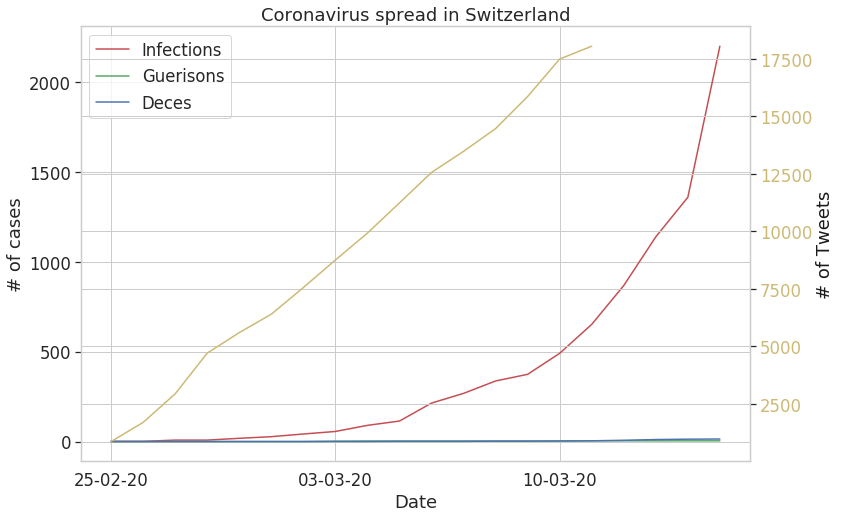

In [31]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'Suisse']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Switzerland")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_CH['date'])]['date'],
    count_CH[count_CH['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Allemagne

In [8]:
count_DE = all_tweets.filter(col('geo_country') == 'DE').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_DE['date'] = pd.to_datetime(count_DE['date'])
count_DE = count_DE.sort_values(by=['date'], ascending=True)

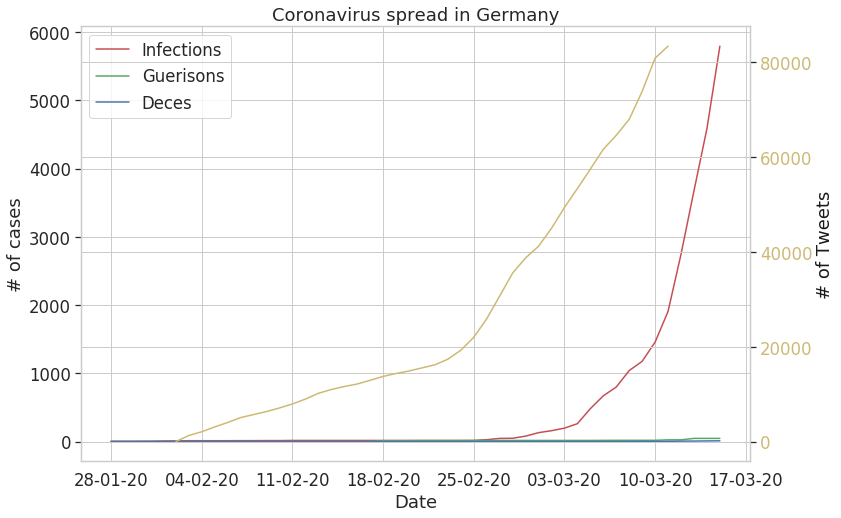

In [32]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'Allemagne']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Germany")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_DE['date'])]['date'],
    count_DE[count_DE['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## USA

In [57]:
count_US = all_tweets.filter(col('geo_country') == 'US').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_US['date'] = pd.to_datetime(count_US['date'])
count_US = count_US.sort_values(by=['date'], ascending=True)

NameError: name 'count_US' is not defined

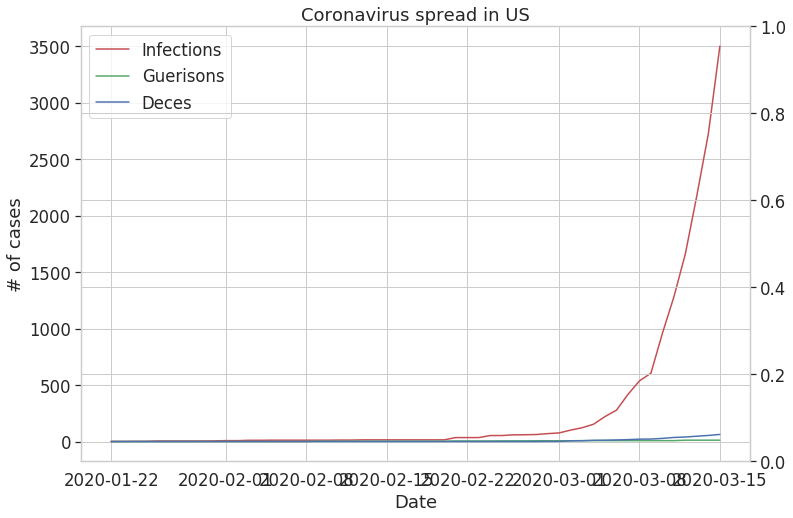

In [33]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'États-Unis']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in US")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_US['date'])]['date'],
    count_US[count_US['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Putting all together

In [27]:
# Merging medias infos

allemagne = pd.read_csv('/mnt/datastore/data/medias/media_allemagne.csv', header=None)
france =  pd.read_csv('/mnt/datastore/data/medias/media_france.csv', header=None)
italy =  pd.read_csv('/mnt/datastore/data/medias/media_italy.csv', header=None)
suisse = pd.concat([pd.read_csv('/mnt/datastore/data/medias/media_suisse_fr.csv', header=None),
                   pd.read_csv('/mnt/datastore/data/medias/media_suisse_de.csv', header=None)])
suisse = suisse.groupby(0).sum().reset_index()

allemagne = allemagne.rename(columns={0: "date", 1:"Medias_DE"})
france = france.rename(columns={0: "date", 1:"Medias_FR"})
italy = italy.rename(columns={0: "date", 1:"Medias_IT"})
suisse = suisse.rename(columns={0: "date", 1:"Medias_CH"})

medias = allemagne.merge(france, how='inner', left_on=['date'], right_on=['date'])
medias = medias.merge(italy, how='inner', left_on=['date'], right_on=['date'])
medias = medias.merge(suisse, how='inner', left_on=['date'], right_on=['date'])

medias['date'] = pd.to_datetime(pd.to_datetime(medias['date']).dt.date)
medias.head()

,date,Medias_DE,Medias_FR,Medias_IT,Medias_CH
0,2020-01-09,105,15,3,19
1,2020-01-10,55,32,0,12
2,2020-01-11,0,0,0,0
3,2020-01-12,0,0,0,1
4,2020-01-13,36,11,0,0


In [29]:
countries = ['France', 'Italie', 'Allemagne', 'Suisse']
iso_countries = ['FR', 'IT', 'DE', 'CH']

#converter = coco.CountryConverter()
#coronavirus_count['Pays'] = coronavirus_count.Pays.apply(lambda x : converter.convert(names = x, src = 'regex', to = 'ISO2'))
coronavirus_merge = coronavirus_count[coronavirus_count['Pays'].isin(countries)]
coronavirus_merge.loc[coronavirus_merge['Pays']=='France','Pays'] = 'FR'
coronavirus_merge.loc[coronavirus_merge['Pays']=='Italie','Pays'] = 'IT'
coronavirus_merge.loc[coronavirus_merge['Pays']=='Allemagne','Pays'] = 'DE'
coronavirus_merge.loc[coronavirus_merge['Pays']=='Suisse','Pays'] = 'CH'

# Gtrend
interest = pd.read_csv('/mnt/datastore/data/gtrend_by_country.csv')
interest = interest[['date','Coronavirus', 'country']]
interest = interest[interest.country.isin(iso_countries)]
interest['date'] = pd.to_datetime(interest['date'])
interest = interest.rename(columns={"Coronavirus": "GTrend"})

# Tweets
tweet_count = all_tweets.filter(col('geo_country').isin(iso_countries)).select(col('geo_country'), F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date", 'geo_country').count().toPandas()
tweet_count['date'] = pd.to_datetime(tweet_count['date'])
tweet_count = tweet_count.sort_values(by=['date'], ascending=True)
tweet_count = tweet_count.rename(columns={"count": "Tweets"})

coronavirus_merge = coronavirus_merge.merge(interest, how='right', left_on=['date', 'Pays'], right_on=['date', 'country']).fillna(0)
coronavirus_merge = coronavirus_merge.merge(tweet_count, how='left', left_on=['date', 'Pays'], right_on=['date', 'geo_country'])
coronavirus_merge= coronavirus_merge.sort_values(by=['date'])

coronavirus_merge = coronavirus_merge[['date', 'country', 'Infections', 'Guerisons', 'Deces', 'GTrend', 'Tweets']]
coronavirus_merge = pd.pivot_table(coronavirus_merge, values=['Infections', 'Deces', 'Guerisons', 'GTrend', 'Tweets'], index=['date'], columns=['country'])
    
coronavirus_merge.columns = ['_'.join(col).strip() for col in coronavirus_merge.columns.values]
coronavirus_merge = coronavirus_merge.reset_index().fillna(method='ffill').fillna(0)
coronavirus_merge = coronavirus_merge.merge(medias, how='right', left_on=['date'], right_on=['date'])

coronavirus_merge.to_csv("/mnt/datastore/data/MediasVsGTrendsVsTweetsVsCorona.csv", index=False)

/home/fanfou/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:

coronavirus_merge['Medias_CH'].sum()

18448

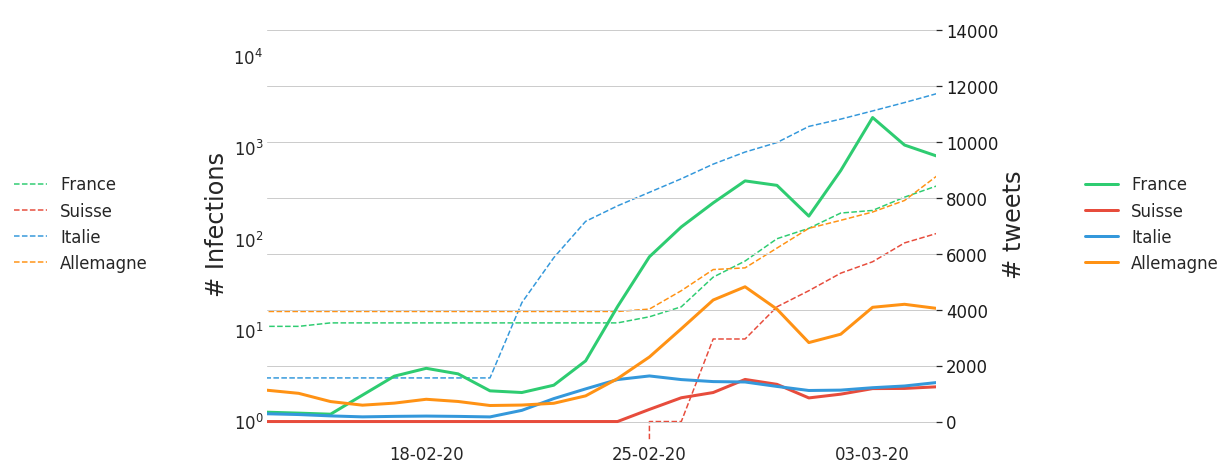

In [97]:
import datetime
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(coronavirus_merge.date,
        coronavirus_merge['Infections_FR'].rolling(window=1).mean(),
        '--',
        color=green_col, label="France", marker='')

ax.plot(coronavirus_merge.date,
        coronavirus_merge['Infections_CH'].rolling(window=1).mean(),
        '--',
        color=red_col, label="Suisse", marker='')

ax.plot(coronavirus_merge.date,
        coronavirus_merge['Infections_IT'].rolling(window=1).mean(),
        '--',
        color=blue_col, label="Italie", marker='')

ax.plot(coronavirus_merge.date,
        coronavirus_merge['Infections_DE'].rolling(window=1).mean(),
        '--',
        color=orange_col, label="Allemagne", marker='')

plt.yscale("log")
ax.set_ylabel('# Infections', fontsize=24)

#ax.set(xlabel="Date",title="")

plt.legend()

ax2 = ax.twinx()
ax2.set_ylabel('# tweets', fontsize=24)

ax2.plot(coronavirus_merge.date,
    coronavirus_merge['Tweets_FR'].rolling(window=2).mean(),
    '', linewidth=3,
    color=green_col, label="France", marker='')

ax2.plot(coronavirus_merge.date,
    coronavirus_merge['Tweets_CH'].rolling(window=2).mean(),
    '', linewidth=3,
    color=red_col, label="Suisse", marker='')

ax2.plot(coronavirus_merge.date,
    coronavirus_merge['Tweets_IT'].rolling(window=2).mean(),
    '', linewidth=3,
    color=blue_col, label="Italie", marker='')

ax2.plot(coronavirus_merge.date,
    coronavirus_merge['Tweets_DE'].rolling(window=2).mean(),
    '', linewidth=3,
    color=orange_col, label="Allemagne", marker='')

ax2.tick_params(axis='y', labelcolor='k')

#plt.yscale("log")

plt.legend()

ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 0.5), frameon=False)

#plt.ylim((10e0, 10e3))

plt.xlim([datetime.date(2020, 2, 13), datetime.date(2020, 3, 5)])

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False);ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);ax2.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False);ax2.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);ax2.spines['left'].set_visible(False)

#plt.show()

plt.savefig("/home/fanfou/Panorama/figures/TweetsVsCorona.pdf", format="pdf")

In [88]:
interest = pd.read_csv('/mnt/datastore/data/gtrend_by_country.csv')
interest = interest[['date','Coronavirus', 'country']]
interest = interest[interest.country.isin(iso_countries)]
interest

,date,Coronavirus,country
0,2019-12-16,0,FR
1,2019-12-17,0,FR
2,2019-12-18,0,FR
3,2019-12-19,0,FR
4,2019-12-20,0,FR
...,...,...,...
445,2020-03-10,78,IT
446,2020-03-11,80,IT
447,2020-03-12,74,IT
448,2020-03-13,65,IT


In [46]:

coronavirus_count[coronavirus_count['Pays'].isin(countries)]

,date,Pays,Infections,Guerisons,Deces
869,2020-01-24,France,2,0,0
870,2020-01-25,France,3,0,0
871,2020-01-26,France,3,0,0
872,2020-01-27,France,3,0,0
873,2020-01-28,France,4,0,0
59,2020-01-28,Allemagne,4,0,0
874,2020-01-29,France,5,0,0
60,2020-01-29,Allemagne,4,0,0
61,2020-01-30,Allemagne,4,0,0
875,2020-01-30,France,5,0,0


In [26]:
interest = pd.read_csv('/mnt/datastore/data/gtrend_by_country.csv')
interest = interest[['date','Coronavirus', 'country']]
interest_it = interest[interest['country'] == 'IT'][['date', 'Coronavirus']]
interest_it = interest_it.rename(columns={"Coronavirus": "interest"})
interest_it['date'] = pd.to_datetime(interest_it['date'])

interest_it.head()

,date,interest
360,2019-12-12,0
361,2019-12-13,0
362,2019-12-14,0
363,2019-12-15,0
364,2019-12-16,0


In [71]:
coronavirus_by_country = pd.pivot_table(coronavirus_count, values=['Infections', 'Deces', 'Guerisons'], index=['date'],
                    columns=['Pays']).fillna(method='ffill').fillna(0)

In [76]:
interest


,date,Coronavirus,isPartial,country
0,2019-12-12,0,False,FR
1,2019-12-13,0,False,FR
2,2019-12-14,0,False,FR
3,2019-12-15,0,False,FR
4,2019-12-16,0,False,FR
...,...,...,...,...
445,2020-03-06,57,False,IT
446,2020-03-07,71,False,IT
447,2020-03-08,78,False,IT
448,2020-03-09,84,False,IT


In [94]:
nb_habitants_it = 60.48e6
nb_habitants_fr = 66.99e6
nb_habitants_ch = 8.57e6
nb_habitants_us = 327.2e6
nb_habitants_de = 82.79e6

blue_col   = "#3498db"
red_col    = "#e74c3c"
green_col  = "#2ecc71"
orange_col = "#ff9214"

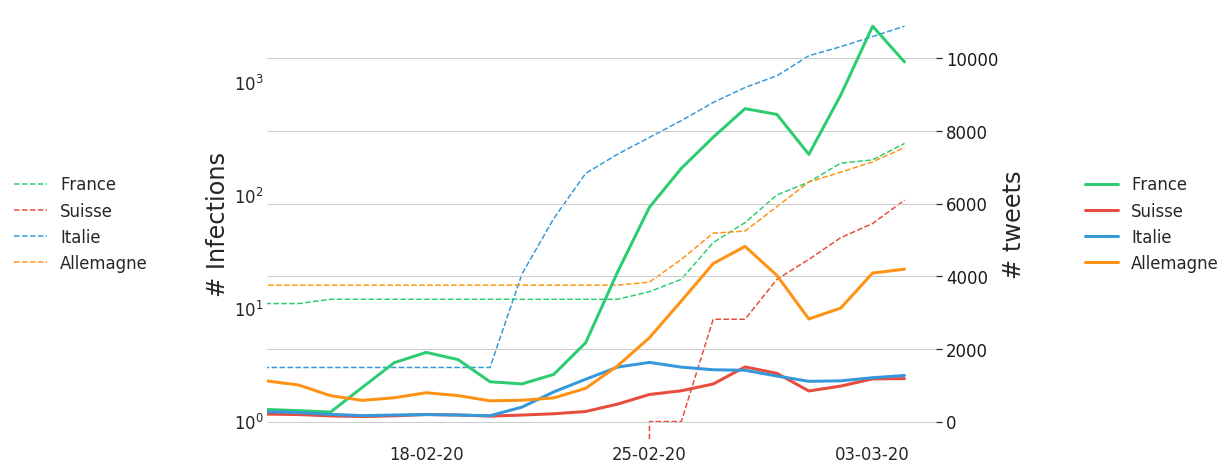

In [319]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'France'].rolling(window=1).mean(),
        '--',
        color=green_col, label="France", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Suisse'].rolling(window=1).mean(),
        '--',
        color=red_col, label="Suisse", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Italie'].rolling(window=1).mean(),
        '--',
        color=blue_col, label="Italie", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Allemagne'].rolling(window=1).mean(),
        '--',
        color=orange_col, label="Allemagne", marker='')

plt.yscale("log")
ax.set_ylabel('# Infections', fontsize=24)

#ax.set(xlabel="Date",title="")

plt.legend()

ax2 = ax.twinx()
ax2.set_ylabel('# tweets', fontsize=24)

dates = coronavirus_count[~coronavirus_count['date'].isin(count_FR['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_FR_norm = count_FR.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_FR_norm['count'] = count_FR['count']/nb_habitants_fr

ax2.plot(coronavirus_by_country.index,
    count_FR_norm[count_FR_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=green_col, label="France", marker='')

dates = coronavirus_count[~coronavirus_count['date'].isin(count_IT['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_IT_norm = count_IT.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_IT_norm['count'] = count_IT['count'] /nb_habitants_it

dates = coronavirus_count[~coronavirus_count['date'].isin(count_CH['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_CH_norm = count_CH.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_CH_norm['count'] = count_CH['count'] /nb_habitants_ch
ax2.plot(coronavirus_by_country.index,
    count_CH_norm[count_CH_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=red_col, label="Suisse", marker='')

ax2.plot(coronavirus_by_country.index,
    count_IT_norm[count_IT_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=blue_col, label="Italie", marker='')

dates = coronavirus_count[~coronavirus_count['date'].isin(count_DE['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_DE_norm = count_DE.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_DE_norm['count'] = count_DE['count'] /nb_habitants_de

ax2.plot(coronavirus_by_country.index,
    count_DE_norm[count_DE_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=orange_col, label="Allemagne", marker='')

ax2.tick_params(axis='y', labelcolor='k')

#plt.yscale("log")

plt.legend()

ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 0.5), frameon=False)

#plt.ylim((10e0, 10e3))

plt.xlim([datetime.date(2020, 2, 13), datetime.date(2020, 3, 5)])

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False);ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);ax2.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False);ax2.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);ax2.spines['left'].set_visible(False)

#plt.show()

plt.savefig("/home/fanfou/Panorama/figures/TweetsVsCorona.pdf", format="pdf")

In [262]:
interest = pd.read_csv('/mnt/datastore/data/gtrend_by_country.csv')
interest_it = interest[interest['country'] == 'IT'][['date', 'Coronavirus']]
interest_it = interest_it.rename(columns={"Coronavirus": "interest"})
interest_it['date'] = pd.to_datetime(interest_it['date'])
interest_it.head()

,date,interest
360,2019-12-12,0
361,2019-12-13,0
362,2019-12-14,0
363,2019-12-15,0
364,2019-12-16,0


In [282]:
medias_it = pd.read_csv('/mnt/datastore/data/medias/media_italy.csv', header=None)
medias_it = medias_it.rename(columns={0: "date", 1:'medias'})
medias_it['date'] = pd.to_datetime(medias_it['date']).dt.strftime('%Y-%m-%d')
medias_it['date'] = pd.to_datetime(medias_it['date'])
medias_it.head()

,date,medias
0,2020-01-09,3
1,2020-01-10,0
2,2020-01-11,0
3,2020-01-12,0
4,2020-01-13,0


In [283]:
print(count_IT['date'].dtype)
print(medias_it['date'].dtype)
print(interest_it['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [268]:
count_IT = count_IT.rename(columns={'count': "tweets"})
count_IT['date'] = pd.to_datetime(count_IT['date'])
count_IT.head()

,date,tweets
5,2019-09-08,2
34,2020-01-02,2
2,2020-01-03,3
45,2020-01-08,3
35,2020-01-09,12


In [285]:
merge = interest_it.merge(medias_it, left_on='date', right_on='date', how='left').fillna(0)
merge = merge.merge(count_IT, left_on='date', right_on='date', how='left').fillna(0)

,date,interest,medias,tweets
0,2019-12-12,0,0.0,0.0
1,2019-12-13,0,0.0,0.0
2,2019-12-14,0,0.0,0.0
3,2019-12-15,0,0.0,0.0
4,2019-12-16,0,0.0,0.0


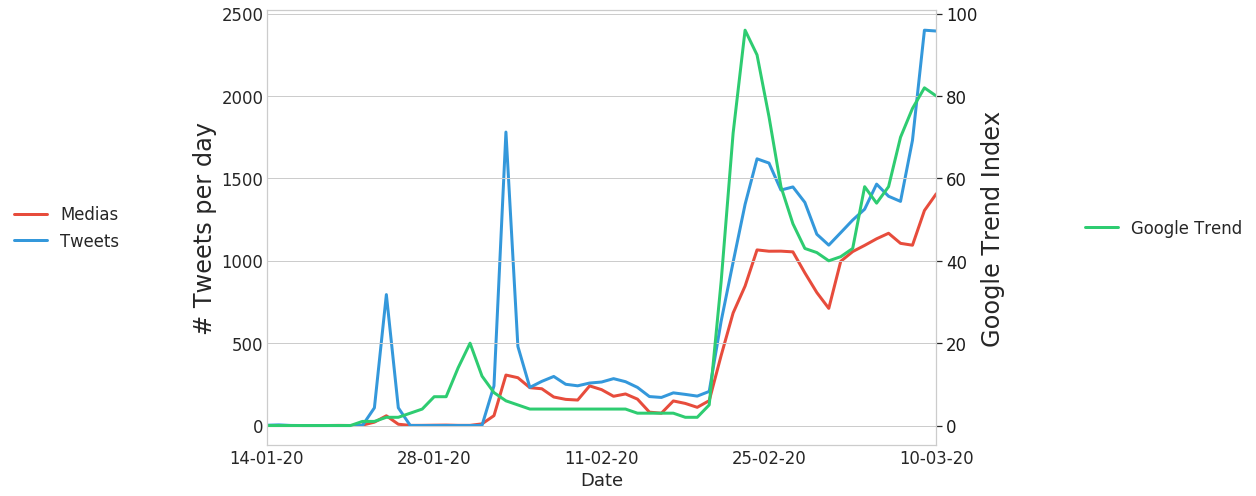

In [316]:
from scipy.ndimage.filters import gaussian_filter1d
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

medias = gaussian_filter1d(merge['medias'], sigma=.5)
ax.plot(merge['date'],
        medias,
        '-', linewidth=3,
        color=red_col, label="Medias", marker='')

#plt.fill_between(merge['date'], medias, facecolor=red_col, alpha=0.5)

tweets = gaussian_filter1d(merge['tweets'], sigma=.5)
ax.plot(merge['date'],
        tweets,
        '-', linewidth=3,
        color=blue_col, label="Tweets", marker='')

#plt.fill_between(merge['date'],tweets, facecolor=blue_col, alpha=0.5)

ax.set_ylabel('# Tweets per day', fontsize=24)
ax.set(xlabel="Date",title="")
plt.legend()


ax2 = ax.twinx()
ax2.set_ylabel('Google Trend Index', fontsize=24)

trends = gaussian_filter1d(merge['interest'], sigma=.5)
ax2.plot(merge['date'],
    trends,
    '', linewidth=3,
    color=green_col, label="Google Trend", marker='')
#plt.fill_between(merge['date'], trends, facecolor=green_col, alpha=0.5)

ax2.tick_params(axis='y', labelcolor='k')

plt.xlim([datetime.date(2020, 1, 14), datetime.date(2020, 3, 10)])
plt.legend()

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 0.5), frameon=False)

ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);
ax.spines['bottom'].set_visible(False);
ax.spines['left'].set_visible(False);



#plt.show()
plt.savefig("/home/fanfou/Panorama/figures/TrendVsMediasVsTweets.pdf", format="pdf")